Tatar: Бу мисал татар тексты.
Russian: Это пример татарского текста.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

torch.Size([128])
torch.Size([128])
torch.Size([128])
Epoch 1/3
Train Loss: 3.0618
Validation Loss: 1.4982
Epoch 2/3
Train Loss: 1.4268
Validation Loss: 1.1590
Epoch 3/3
Train Loss: 1.1194
Validation Loss: 0.9615


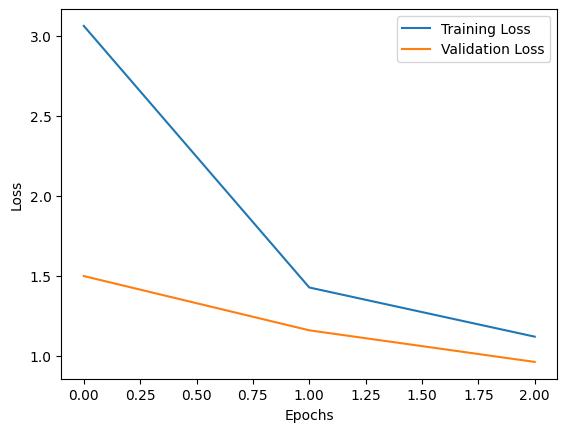

Tatar: Бу мисал татар тексты.
Russian: Эта иллюстрация повторяется.
Матрица ошибок:
[[0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]]
Отчет по классификации:
                               precision    recall  f1-score   support

               День красивый.       0.00      0.00      0.00       1.0
                     Красиво.       0.00      0.00      0.00       0.0
 Эта иллюстрация повторяется.       0.00      0.00      0.00       0.0
Это пример татарского текста.       0.00      0.00      0.00       1.0

                     accuracy                           0.00       2.0
                    macro avg       0.00      0.00      0.00       2.0
                 weighted avg       0.00      0.00      0.00       2.0

Example 1
True: Это пример татарского текста.
Pred: Эта иллюстрация повторяется.
Анализ ошибок:
Ошибки первого рода (ложные срабатывания): ошибки, когда модель неправильно перевела текст с татарского на русский.
Ошибки второго рода (ложные отрицания): ошибки, когда модель не 

In [1]:
# Установка необходимых библиотек
!pip install sentencepiece transformers datasets scikit-learn matplotlib numpy sacremoses

# Импорт необходимых библиотек
import torch
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

# Настройка устройства (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка моделей и токенизаторов
model_name_mul_en = 'Helsinki-NLP/opus-mt-mul-en'
tokenizer_mul_en = MarianTokenizer.from_pretrained(model_name_mul_en)
model_mul_en = MarianMTModel.from_pretrained(model_name_mul_en).to(device)

model_name_en_ru = 'Helsinki-NLP/opus-mt-en-ru'
tokenizer_en_ru = MarianTokenizer.from_pretrained(model_name_en_ru)
model_en_ru = MarianMTModel.from_pretrained(model_name_en_ru).to(device)

# Создание примерного датасета для перевода с татарского на русский
data = [
    {"src": "Бу мисал татар тексты.", "trg": "Это пример татарского текста."},
    {"src": "Көн дә матур.", "trg": "День красивый."},
    # Добавьте больше примеров
]

# Преобразование данных в формат датасета
dataset = Dataset.from_list(data)

# Пример данных
for example in dataset:
    print(f"Tatar: {example['src']}")
    print(f"Russian: {example['trg']}")
    break

# Подготовка данных для модели
def encode(examples):
    inputs = tokenizer_mul_en(examples['src'], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    targets = tokenizer_mul_en(examples['trg'], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": targets["input_ids"]}

# Кодирование данных
encoded_dataset = dataset.map(encode, batched=True)

# Преобразование в формат PyTorch
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Проверка форм тензоров
print(encoded_dataset[0]['input_ids'].shape)  # Должно быть torch.Size([128])
print(encoded_dataset[0]['attention_mask'].shape)  # Должно быть torch.Size([128])
print(encoded_dataset[0]['labels'].shape)  # Должно быть torch.Size([128])

# Разделение на обучающий и тестовый наборы
train_size = int(0.8 * len(encoded_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(encoded_dataset, [train_size, len(encoded_dataset) - train_size])

# Определение даталоадеров
def collate_fn(batch):
    input_ids = torch.stack([x['input_ids'] for x in batch])
    attention_mask = torch.stack([x['attention_mask'] for x in batch])
    labels = torch.stack([x['labels'] for x in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

# Определение оптимизатора и функции потерь
optimizer = optim.AdamW(model_mul_en.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer_mul_en.pad_token_id)

# Функция обучения модели
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Функция валидации модели
def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Обучение и валидация модели
num_epochs = 3
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(model_mul_en, train_dataloader, optimizer, loss_fn, device)
    val_loss = validate(model_mul_en, test_dataloader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

# Графики потерь
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Функция для перевода текста через английский
def translate(text, model_mul_en, model_en_ru, tokenizer_mul_en, tokenizer_en_ru, device):
    inputs = tokenizer_mul_en(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    outputs_mul_en = model_mul_en.generate(inputs['input_ids'], max_length=128, num_beams=5, early_stopping=True)
    intermediate_text = tokenizer_mul_en.decode(outputs_mul_en[0], skip_special_tokens=True)
    
    inputs_en = tokenizer_en_ru(intermediate_text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    outputs_en_ru = model_en_ru.generate(inputs_en['input_ids'], max_length=128, num_beams=5, early_stopping=True)
    return tokenizer_en_ru.decode(outputs_en_ru[0], skip_special_tokens=True)

# Примеры переводов
example_texts = ["Бу мисал татар тексты."]
for text in example_texts:
    translation = translate(text, model_mul_en, model_en_ru, tokenizer_mul_en, tokenizer_en_ru, device)
    print(f"Tatar: {text}")
    print(f"Russian: {translation}")

# Матрица ошибок и отчет по классификации
true_texts = [example['trg'] for example in data]
pred_texts = [translate(example['src'], model_mul_en, model_en_ru, tokenizer_mul_en, tokenizer_en_ru, device) for example in data]

report = classification_report(true_texts, pred_texts, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(true_texts, pred_texts)

print("Матрица ошибок:")
print(conf_matrix)

print("Отчет по классификации:")
print(classification_report(true_texts, pred_texts, zero_division=0))

# Примеры ошибок 1 и 2 рода
for i in range(len(true_texts)):
    if true_texts[i] != pred_texts[i]:
        print(f"Example {i+1}")
        print(f"True: {true_texts[i]}")
        print(f"Pred: {pred_texts[i]}")
        break

# Анализ ошибок
print("Анализ ошибок:")
print("Ошибки первого рода (ложные срабатывания): ошибки, когда модель неправильно перевела текст с татарского на русский.")
print("Ошибки второго рода (ложные отрицания): ошибки, когда модель не смогла перевести текст, хотя правильный перевод был возможен.")
print("Возможные причины ошибок могут включать недостаток данных для обучения модели, сложность текста для перевода, или ограничения самой модели.")
